In [34]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from seaborn import plotting_context

In [97]:
con = duckdb.connect()
systems = sorted(['clickhouse', 'duckdb', 'hyper']) # 'databend', 'umbra'
for system in systems: # TODO: ATTACH IF NOT EXISTS has not been merged yet
    con.execute(f"""ATTACH '../results/{system}.db' AS {system} (READ_ONLY TRUE);""")
con.execute(f"""CREATE VIEW IF NOT EXISTS all_results AS ({' UNION ALL '.join([f"SELECT '{system}' AS system, * FROM {system}.main.results" for system in systems])})""")
results_df = con.execute("""SELECT * REPLACE (median(runtime) AS runtime, sf::VARCHAR as sf) FROM all_results GROUP BY ALL ORDER BY ALL""").fetchdf()
results_df.head()

,system,sf,grouping,wide,runtime
0,clickhouse,1,l_orderkey,False,0.072056
1,clickhouse,1,l_orderkey,True,0.391400
2,clickhouse,1,l_orderkey-l_partkey,False,0.107392
3,clickhouse,1,l_orderkey-l_partkey,True,0.543701
4,clickhouse,1,l_orderkey-l_returnflag-l_linestatus,False,0.236514


In [106]:
my_style = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.0',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
    'DejaVu Sans',
    'Liberation Sans',
    'Bitstream Vera Sans',
    'sans-serif'],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': 'white',
    'axes.edgecolor': '.0',
    'grid.color': '.8',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}

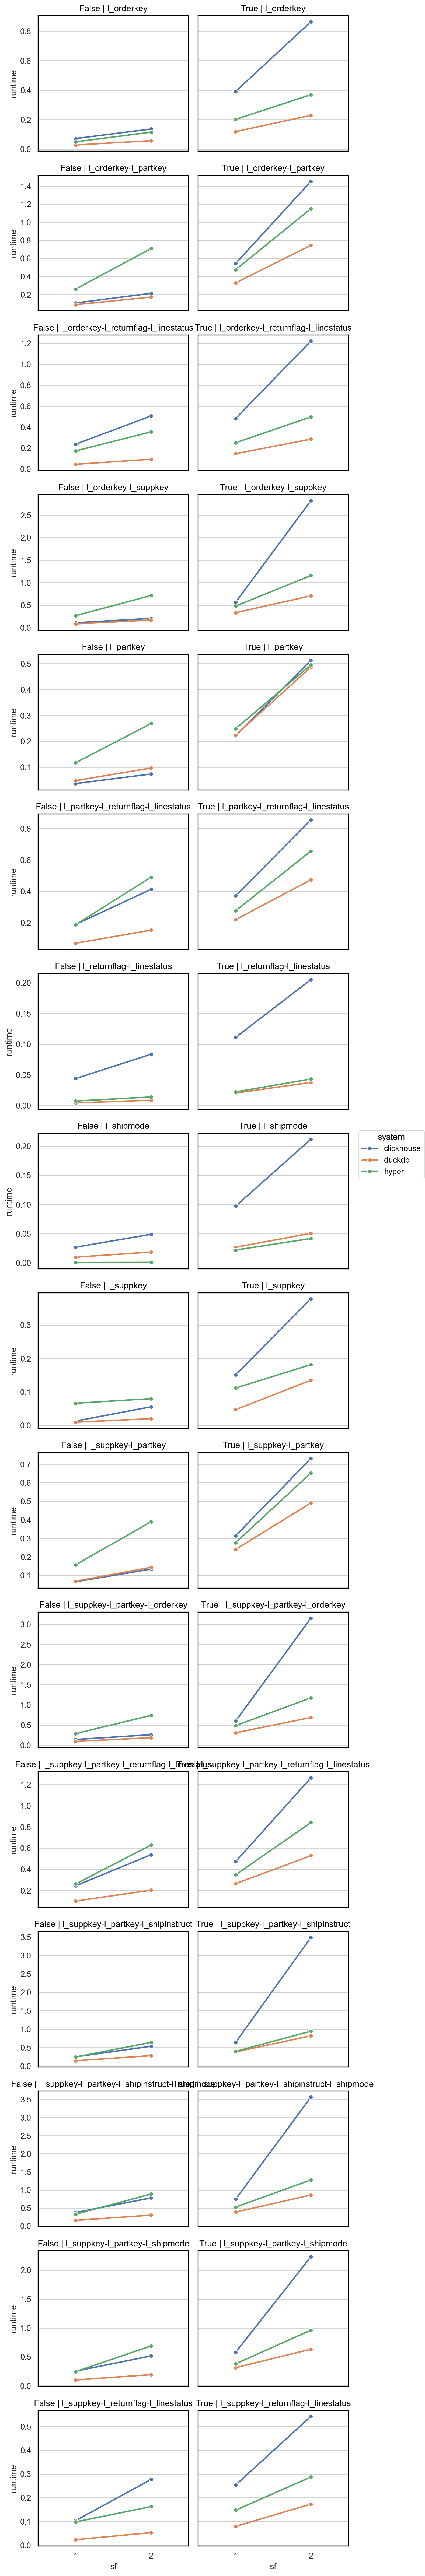

In [107]:
p = (
    so.Plot(results_df, x='sf', y='runtime', color='system')
    .facet(col='wide', row='grouping')
    .add(so.Line(linewidth=2, marker='o', edgecolor='w'))
    .share(x='col', y='row')
    .layout(size=(7, 50), engine='tight')
    .theme(my_style)
)
p